In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [241]:
#Apply logit to prior distribution of beta_0
def logit(x):
    return np.log(x / (1 - x))

#Apply invlogit to get value in 0,1
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

In [405]:
#Define Euler Murayama SIR that computes the discretization for paths between t and t+1 day
def one_step_euler_maruyama_SUIRD(num_particles, m, N, initial_states, params):
    # Define the logit transformation
    dt = 1/m
    
    alpha, gamma, sigma_R0, sigma_rho = params

    num_states = initial_states.shape[1]
    
    states = np.zeros((m+1,num_particles,num_states))
    
    states[0,:,:] = initial_states
        
    for t in range(1, m):
        dW5 = np.random.normal(0, np.sqrt(dt), size=num_particles) 
        dW6 = np.random.normal(0, np.sqrt(dt), size=num_particles) 

        states[t, :, 4] = states[t-1, :, 4] + sigma_R0 * dW5
        states[t, :, 5] = states[t-1, :, 5] + sigma_rho * dW6
        
        R0 = np.exp(states[t, :, 4])
        rho = inv_logit(states[t, :, 5])
        
        dS = -(gamma+rho+alpha)*R0*states[t-1, :, 0]*(states[t-1, :, 1] + states[t-1, :, 1])/N + alpha*states[t-1, :, 3]
        dU =  (gamma+rho+alpha)*R0*states[t-1, :, 0]*(states[t-1, :, 1] +states[t-1, :, 1])/N - rho*states[t-1, :, 1]
        dI =  rho*states[t-1, :, 1] - gamma*states[t-1, :, 2] 
        dR =  gamma*states[t-1, :, 2] - alpha*states[t-1, :, 3]
        
        states[t, :, 0] = states[t-1, :, 0] + dS*dt
        states[t, :, 1] = states[t-1, :, 1] + dU*dt
        states[t, :, 2] = states[t-1, :, 2] + dI*dt
        states[t, :, 3] = states[t-1, :, 3] + dR*dt
        
    return states[-1,:,:]

In [410]:
# Parameters
N = 1000  # Total population
num_particles = 1
m = 10
alpha = 0.1# Rate of immunity loss
gamma = 0.1
sigma_R0 = 0.05
sigma_rho = 0.05


params = (alpha, gamma, sigma_R0, sigma_rho)

# Initial conditions
U0 = stats.uniform(10,20).rvs(num_particles)
I0 = np.zeros(num_particles)
R0 = np.zeros(num_particles)
S0 = N - U0 - I0 - R0

X0 = np.log(stats.uniform(1,2).rvs(num_particles))
Y0 = logit(stats.uniform(0.2,0.8).rvs(num_particles))


initial_states = np.column_stack((S0, U0, I0, R0, X0, Y0))

initial_states

array([[9.77534480e+02, 2.24655195e+01, 0.00000000e+00, 0.00000000e+00,
        6.96706861e-01, 1.27720057e+00]])

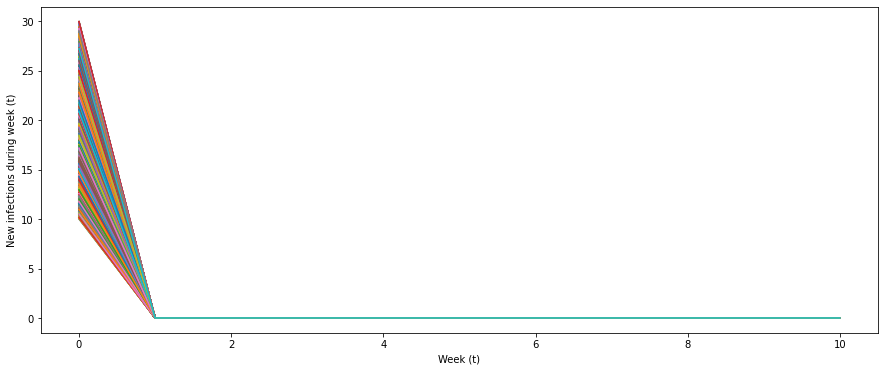

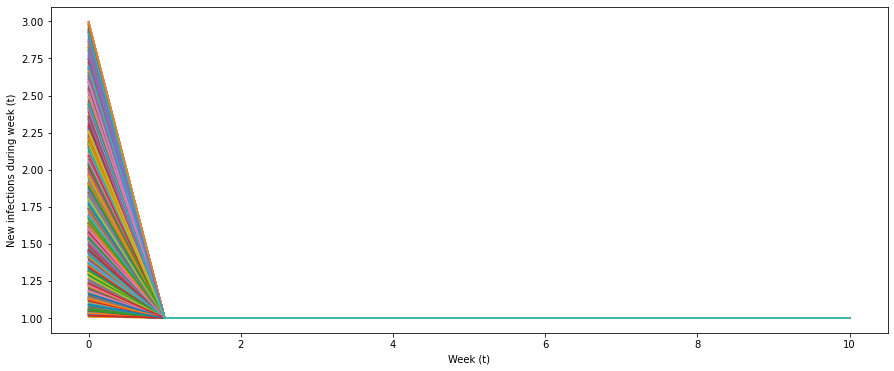

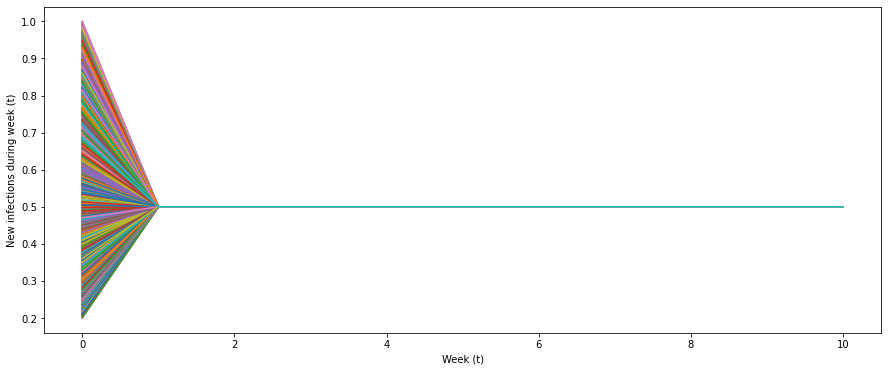

In [411]:
# Parameters
N = 1000000  # Total population
num_particles = 1000
m = 100
alpha = 0.1# Rate of immunity loss
gamma = 0.1
sigma_R0 = 0.05
sigma_rho = 0.05


params = (alpha, gamma, sigma_R0, sigma_rho)

# Initial conditions
U0 = stats.uniform(10,20).rvs(num_particles)
I0 = np.zeros(num_particles)
R0 = np.zeros(num_particles)
S0 = N - U0 - I0 - R0

X0 = np.log(stats.uniform(1,2).rvs(num_particles))
Y0 = logit(stats.uniform(0.2,0.8).rvs(num_particles))


initial_states = np.column_stack((S0, U0, I0, R0, X0, Y0))
num_states = initial_states.shape[1]

# Simulate the SIR model for t = 50 periods
T = 10

state_values = np.zeros((T+1, num_particles, num_states))

# Initial conditions for the first simulation
state_values[0,:,:] = initial_states

for t in np.arange(1,T+1):
    # Simulate the SIR model
    final_states = one_step_euler_maruyama_SUIRD(num_particles, m, N, initial_states, params)
    
    # Store the final states
    state_values[t,:,:] = final_states
    
    # Update initial conditions for the next simulation
    initial_states = final_states


# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),state_values[:,:,1])
plt.ylabel('New infections during week (t)')
plt.xlabel('Week (t)')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),np.exp(state_values[:,:,4]))
plt.ylabel('New infections during week (t)')
plt.xlabel('Week (t)')
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),inv_logit(state_values[:,:,5]))
plt.ylabel('New infections during week (t)')
plt.xlabel('Week (t)')
plt.show()

In [272]:
#Define Euler Murayama SIR that computes the discretization for paths between t and t+1 day
def one_step_euler_maruyama_sir(num_particles, m, N, initial_states, params):
    dt = 1/m
    alpha, sigma_b, sigma_g = params

    num_states = initial_states.shape[1]
    
    states = np.zeros((m+1,num_particles,num_states))
    
    states[0,:,:] = initial_states
        
    for t in range(1, m+1):
        dWg = np.random.normal(0, np.sqrt(dt), size=num_particles) 
        dWb = np.random.normal(0, np.sqrt(dt), size=num_particles) 
        
        states[t, :, 3] = states[t-1, :, 3] + sigma_b * dWg
        states[t, :, 4] = states[t-1, :, 4] + sigma_g * dWb
        
        beta = inv_logit(states[t,:,3])
        gamma = inv_logit(states[t,:,4])
        #RT = np.exp(states[t, :, 3])
        
        dS = -beta*states[t-1, :, 0]*states[t-1, :, 1]/N + alpha*states[t-1, :, 2]
        dI =  beta*states[t-1, :, 0]*states[t-1, :, 1]/N - gamma*states[t-1, :, 1]
        dR =  gamma*states[t-1, :, 1] - alpha*states[t-1, :, 2]
        
        states[t, :, 0] = states[t-1, :, 0] + dS*dt
        states[t, :, 1] = states[t-1, :, 1] + dI*dt
        states[t, :, 2] = states[t-1, :, 2] + dR*dt
        
    return states[-1,:,:]

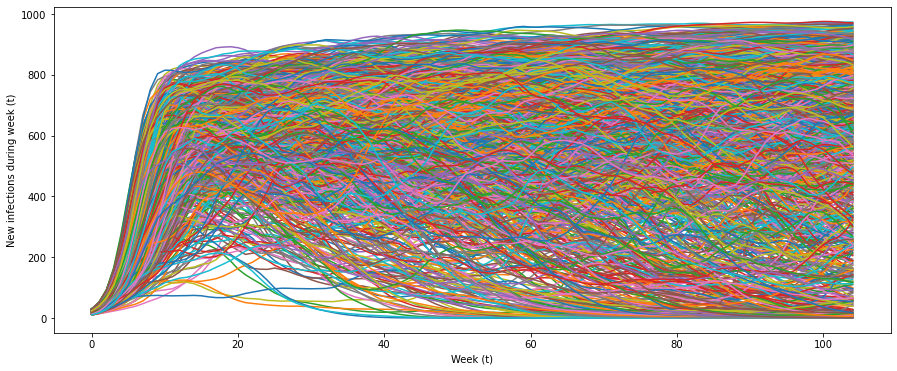

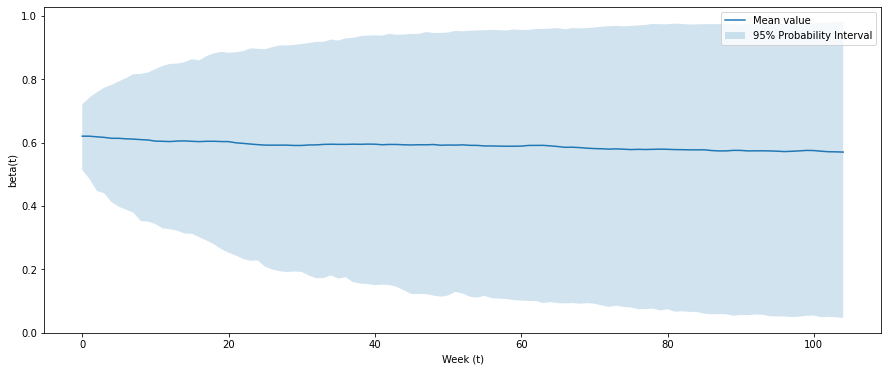

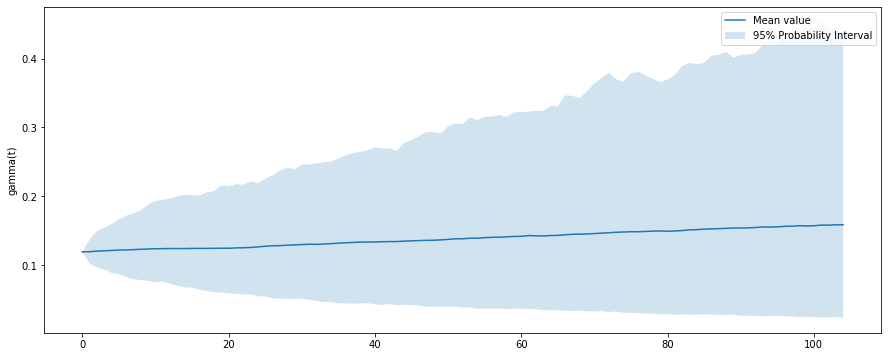

In [352]:
# Parameters
N = 1000  # Total population
num_particles = 1000
m = 10
alpha = 1/2  # Rate of immunity loss
sigma_b = 0.2# Diffusion coefficient
sigma_g = 0.1# Diffusion coefficient


params = (alpha, sigma_b, sigma_g)

# Initial conditions
I0 = stats.uniform(10,20).rvs(num_particles)
S0 = N - I0
R0 = np.zeros(num_particles)
X0 = stats.uniform(0,1).rvs(num_particles)
Y0 = stats.uniform(-2,0).rvs(num_particles)


initial_states = np.column_stack((S0, I0, R0, X0, Y0))
num_states = initial_states.shape[1]

# Simulate the SIR model for t = 50 periods
T = 104
state_values = np.zeros((T+1, num_particles, num_states))

# Initial conditions for the first simulation
state_values[0,:,:] = initial_states

for t in np.arange(1,T+1):
    # Simulate the SIR model
    final_states = one_step_euler_maruyama_sir(num_particles, m, N, initial_states, params)
    
    # Store the final states
    state_values[t,:,:] = final_states
    
    # Update initial conditions for the next simulation
    initial_states = final_states


# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),state_values[:,:,1])
plt.ylabel('New infections during week (t)')
plt.xlabel('Week (t)')
plt.show()

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),np.mean(inv_logit(state_values[:,:,3]), axis=1), label = 'Mean value')
plt.fill_between(np.arange(T+1), np.percentile(inv_logit(state_values[:,:,3]),5, axis=1), np.percentile(inv_logit(state_values[:,:,3]),95, axis=1), alpha=0.2, label='95% Probability Interval')
plt.ylabel('beta(t)')
plt.xlabel('Week (t)')
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(np.arange(T+1),np.mean(inv_logit(state_values[:,:,4]), axis=1), label = 'Mean value')
plt.fill_between(np.arange(T+1), np.percentile(inv_logit(state_values[:,:,4]),5, axis=1), np.percentile(inv_logit(state_values[:,:,4]),95, axis=1), alpha=0.2, label='95% Probability Interval')
plt.ylabel('gamma(t)')
plt.legend()
plt.show()

In [6]:
def sir_bootstrap_particle_filter(y, parameters, num_particles, m, initial_states):
    num_compartments = initial_states.shape[1]  # S, I, R, X, Y
    t_max = y.shape[0]
        
    particles = np.zeros((t_max, num_particles, num_compartments))
    weights = np.zeros((t_max, num_particles))
    norm_weights = np.zeros((t_max, num_particles))
    ancestry_matrix = np.zeros((t_max, num_particles))
    ESS = np.zeros(t_max)
    
    # Initialization
    particles[0, :, 0] = initial_states[:,0]     # S_t
    particles[0, :, 1] = initial_states[:,1]     # I_t              
    particles[0, :, 2] = initial_states[:,2]     # R_t 
    particles[0, :, 3] = initial_states[:,3]     # X_t - beta
    particles[0, :, 4] = initial_states[:,4]     # Y_t - gamma

    incremental_weights = stats.norm(particles[0, :, 1], 10).logpdf(y[0]) 
    max_weights = np.max(incremental_weights)
    weights[0, :] = np.exp(incremental_weights-max_weights) 
    weights_sum = np.sum(weights[0,:])
    norm_weights[0,:] = weights[0,:] / weights_sum
    
    ancestry_matrix[0,:] = np.arange(num_particles)
    loglikelihood =  max_weights + np.log(weights_sum) - np.log(num_particles)
    ESS[0] = 1 / np.sum(norm_weights**2)
    
    for t in range(1, t_max):
        if ESS[t-1] < 0.5*num_particles:
            #Systemtic resampling
            cumulative_sum = np.cumsum(norm_weights[t-1,:])
            random_start = np.random.uniform(0, 1/num_particles)
            new_ancestors = np.zeros(num_particles, dtype=int)
            for i in range(num_particles):
                idx = np.searchsorted(cumulative_sum, random_start + i/num_particles)
                new_ancestors[i] = idx
            
            #Multinomial resampling
            #new_ancestors = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[t-1,:], replace=True) #resample particles
        
            # Update the ancestry matrix
            ancestry_matrix[1:t-1,:] = ancestry_matrix[1:t-1, new_ancestors]
            ancestry_matrix[t,:] = new_ancestors
        else:
            new_ancestors = ancestry_matrix[t-1,:].astype(int)
            ancestry_matrix[t,:] = new_ancestors
            
        #State Transition with Euler-Murayama for m steps
        particles[t, :, :] = one_step_euler_maruyama_sir(num_particles, m, N, particles[t-1, new_ancestors, :], parameters)
        
        #Compute Weights
        incremental_weights = stats.norm(particles[t, :, 1], 10).logpdf(y[t]) 
        max_weights = np.max(incremental_weights)
        weights[t, :] = np.exp(incremental_weights-max_weights) #*weights[t-1, :]
        weights_sum = np.sum(weights[t,:])
        norm_weights[t,:] = weights[t,:] / weights_sum
        ESS[t] = 1 / np.sum(norm_weights**2)
        
        loglikelihood += max_weights + np.log(weights_sum) - np.log(num_particles)
    return loglikelihood, norm_weights, particles, ancestry_matrix, ESS

In [7]:
covid = pd.read_csv('/Users/ro/Desktop/UNDERGRAD_AM_THESIS/national_weekly.csv',  parse_dates=['Date'], index_col=False)
# Set the index to the dates column
covid.set_index('Date', inplace=True)
# Display the DataFrame to verify
covid.head()

,Infections,Deaths,Year
Date,,,
2020-02-23,4.0,0.0,2020
2020-03-01,22.0,0.0,2020
2020-03-08,127.0,0.0,2020
2020-03-15,621.0,0.0,2020
2020-03-22,1146.0,6.0,2020


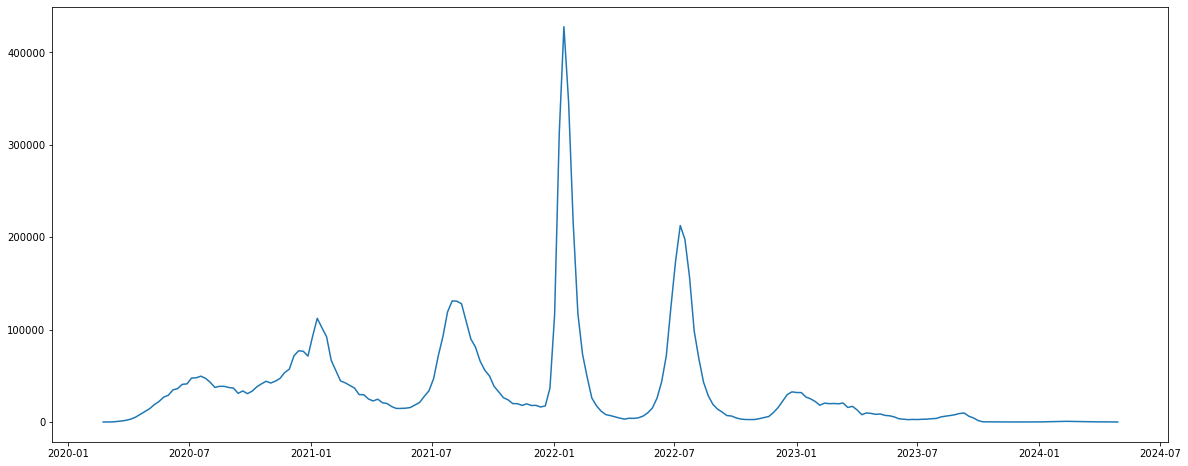

In [154]:
test_data = covid['Infections']
plt.figure(figsize=(20,8))
plt.plot(test_data)
plt.show()

In [155]:
def sample_trajectory(ancestry_matrix, particles_matrix):
    num_time_steps = particles_matrix.shape[0]
    num_particles = particles_matrix.shape[1]
    num_states = particles_matrix.shape[2]
    trajectory = np.zeros((num_time_steps, num_states))  # Initialize the trajectory array
    
    # Sample the particle index from the last time step
    sampled_index = np.random.choice(np.arange(num_particles)).astype(int)
    trajectory[-1,:] = particles_matrix[-1,sampled_index,:]
    
    # Recursively sample particles from previous time steps
    for t in range(num_time_steps - 2, -1, -1):  # Iterate backward in time
        # Get the ancestor index at the previous time step
        sampled_index = ancestry_matrix[t, sampled_index].astype(int)
        # Update the trajectory array with the state from the particles matrix
        trajectory[t,:] = particles_matrix[t, sampled_index,:]
    
    return trajectory

In [226]:
logit(0.99)

4.595119850134589

In [227]:
inv_logit(4.5)

0.9890130573694068

In [228]:
num_particles = 500
num_iterations = 5000
num_time_steps = test_data.shape[0]

N = 127792286  # Total population
m = 7


I0 = stats.uniform(1,10).rvs(num_particles)
S0 = N - I0
R0 = np.zeros(num_particles)
beta0 = 0.5
gamma0 = 0.2
X0 = logit(stats.uniform(0.5,4.5).rvs(num_particles))
Y0 = logit(stats.truncnorm(0.5,4.5).rvs(num_particles))

initial_states = np.column_stack((S0, I0, R0, X0, Y0))
num_states = initial_states.shape[1]
num_compartments = initial_states.shape[1]

estimated_alpha = np.zeros((num_iterations))
estimated_sigmab = np.zeros((num_iterations))
estimated_sigmag = np.zeros((num_iterations))

trajectories = np.zeros((num_iterations,num_time_steps, num_states))
loglikelihood = np.zeros((num_iterations))

alpha_current = 0.8
sigmab_current = 0.8
sigmag_current = 0.5

params_initial = (alpha_current, sigmab_current, sigmag_current)

estimated_alpha[0] = alpha_current
estimated_sigmab[0] = sigmab_current
estimated_sigmag[0] = sigmag_current

accepted = 0

likelihood_current, _, particles, ancestry_matrix, _ = sir_bootstrap_particle_filter(test_data, params_initial, num_particles, m, initial_states)
trajectories[0,:,:] = sample_trajectory(ancestry_matrix, particles)
loglikelihood[0] = likelihood_current
print(loglikelihood[0])
# Perform PMMH iterations
for i in range(num_iterations):
    # Propose a new value for X0
    alpha_proposed = np.random.normal(alpha_current, 0.1)
    sigmab_proposed = np.random.normal(sigmab_current, 0.1)
    sigmag_proposed = np.random.normal(sigmag_current, 0.1)
        
    if (0 < alpha_proposed < 1) and (0 < sigmab_proposed) and (0 < sigmab_proposed):
        params_proposed = (alpha_proposed, sigmab_proposed, sigmab_proposed)
        likelihood_proposed, _, particles, ancestry_matrix, _  = sir_bootstrap_particle_filter(test_data, params_proposed, num_particles, m, initial_states)
        trajectory_proposed = sample_trajectory(ancestry_matrix, particles)
    
    # Calculate acceptance probability
    acceptance_prob = min(1, np.exp(likelihood_proposed - likelihood_current))
    acceptance_prob *= (0 < alpha_proposed < 1)
    acceptance_prob *= (0 < sigmab_proposed)
    acceptance_prob *= (0 < sigmab_proposed)

    u = stats.uniform(0,1).rvs()
    # Accept or reject the proposal
    if u < acceptance_prob:
        alpha_current = alpha_proposed
        sigmab_current = sigmab_proposed
        sigmag_current = sigmag_proposed
        likelihood_current = likelihood_proposed
        
        trajectories[i,:,:] = trajectory_proposed
        accepted += 1
    else:
        trajectories[i,:,:] = trajectories[i-1,:,:]
        
    estimated_alpha[i] = alpha_current
    estimated_sigmab[i] = sigmab_current
    estimated_sigmag[i] = sigmag_current
    loglikelihood[i] = likelihood_current
    
    if (i % 1000 == 0) and (i>0):
        print('Acceptance rate: ', accepted/(i))
        print('Loglikelihood: ', loglikelihood[i])
        print('Alpha: ', alpha_current)
        print('Sigma_b: ', sigmab_current)
        print('Sigma_g: ', sigmag_current)

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_66141/2410667054.py:11: RuntimeWarning: invalid value encountered in log
  return np.log(beta / (1 - beta))


nan


KeyboardInterrupt: 

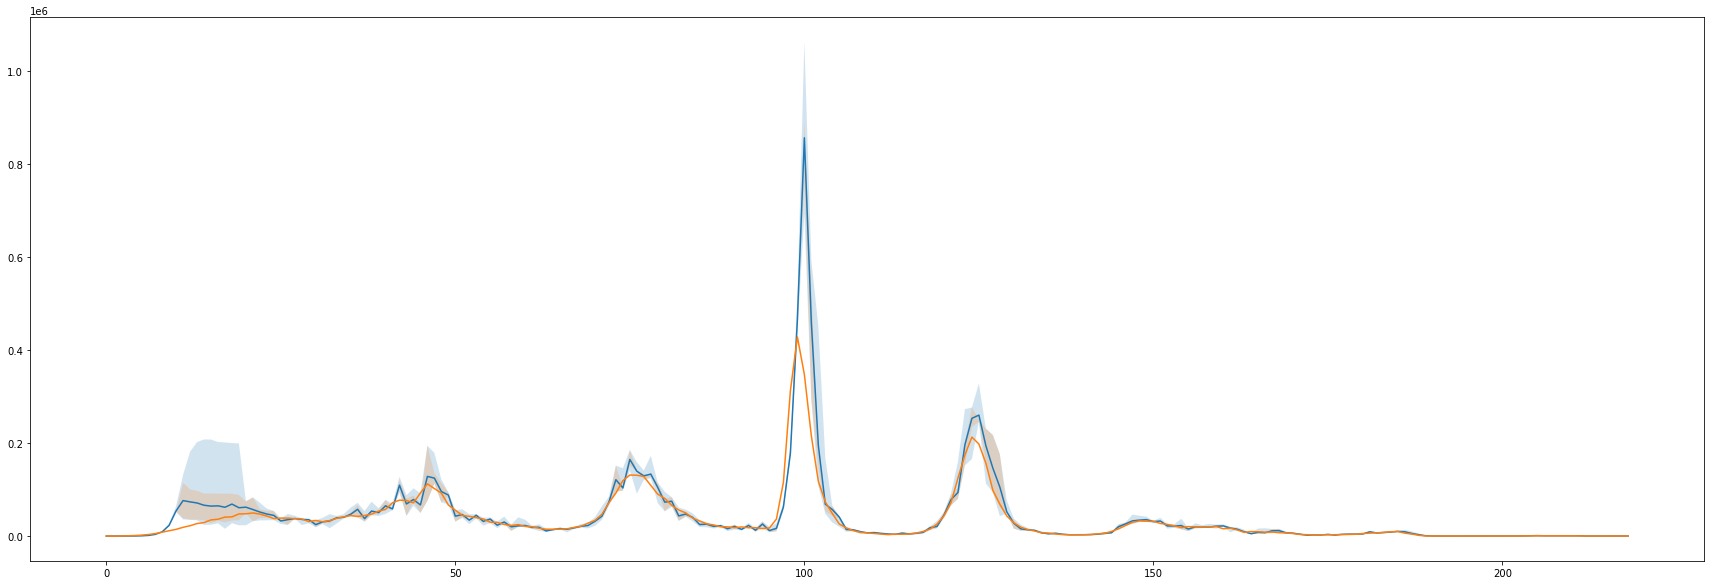

In [218]:
plt.figure(figsize=(30,10))
plt.plot(np.mean(trajectories[:,:,1], axis=0))
plt.fill_between(np.arange(test_data.shape[0]),np.percentile(trajectories[:,:,1],2.5, axis=0), np.percentile(trajectories[:,:,1],97.5, axis=0), alpha=0.2, label='95% Probability Interval')
plt.fill_between(np.arange(test_data.shape[0]),np.percentile(trajectories[:,:,1],25, axis=0), np.percentile(trajectories[:,:,1],75, axis=0), alpha=0.2, label='95% Probability Interval')
plt.plot(test_data.values)

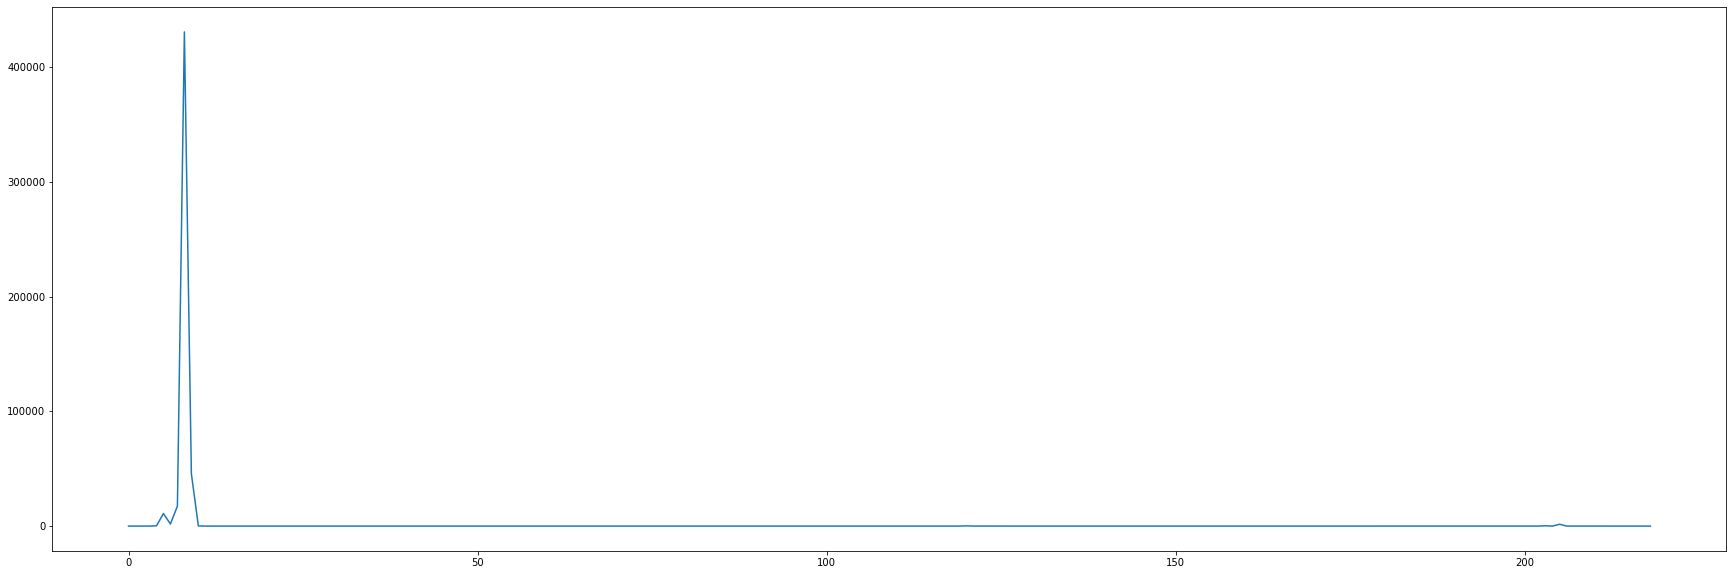

In [217]:
plt.figure(figsize=(30,10))
plt.plot(np.arange(test_data.shape[0]),np.median(inv_logit(trajectories[:,:,3]) / inv_logit(trajectories[:,:,4]), axis=0))
                                                 
plt.show()



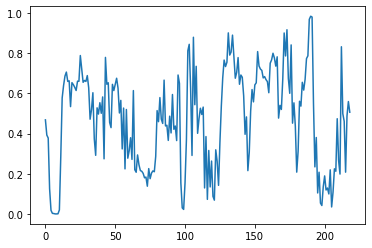

In [162]:
plt.plot(np.mean(inv_logit(trajectories[:,:,4]), axis=0))